## <font color=darkcyan> Estimation des paramètres de la loi Gamma </font>

La densité de la  loi Gamma $\Gamma(a,b)$ est donnée sur $\mathbb{R}_+^*$ par
$$f_{(a,b)}: x \mapsto \frac{b^a}{\Gamma(a)}x^{a-1}e^{-bx},$$
avec des paramètres $a>0$ et $b>0$.  

Soit $\mathbf x=(x_1,\dots,x_n)$ une réalisation de $\mathbf X=(X_1,\dots,X_n)$ où les $X_i$ sont  i.i.d. de la loi Gamma $\Gamma(a,b)$.

L'objectif de ce TP est l'estimation des paramètres $a$ et $b$ à partir des observations  $\mathbf x$.


#### <font color=darkorange> Estimateur du maximum de vraisemblance </font>

La lograisemblance de ce modèle s'écrit
$$\ell: (a,b) \mapsto \sum_{i=1}^n\log f_{(a,b)}(x_i)= na\log(b) -n\log(\Gamma(a)) +(a-1)\sum_{i=1}^n\log(x_i) -b\sum_{i=1}^nx_i.$$

L'estimateur du maximum de vraisemblance de $a$ et $b$ est donné par
$$(\hat a, \hat b) = \mathrm{argmax}_{a>0,b>0}\{\ell(a,b)\}.$$





#### Question 1

- Ecrire une fonction qui évalue la logvraisemblance $\ell(a,b)$. Elle prend en argument des valeurs pour les paramètres $a$ et $b$ et les observations $\mathbf x=(x_1,\dots,x_n)$. Pour calculer la fonction Gamma on pourra utiliser `math.gamma`. On choisira pour commencer l'exemple `a=2` et `b=0.5`.
- Vérifiez votre calcul avec la méthode `log_pdf` de `from scipy.stats import gamma`
- Générez un échantillon de taille `n=5000` avec les paramètres précédents et tracez l'histogramme correspondant que vous comparerez à la densité de la loi Gamma (utilisez la méthode `gamma.pdf`).

In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

def gamma_logpdf(x,a,beta):
    """
    Inputs
    ----------
    x: samples
    a: shape parameter of the Gamma distribution
    beta: inverse of the scale parameter of the Gamma distribution
    
    Outputs
    -------
    logp: loglikelihood of the samples
    """

    # A completer
    n = len(x)
    return n*a*math.log(beta) - n*math.log(math.gamma(a)) + (a-1)*np.sum(np.log(x)) - beta*np.sum(x)

In [7]:
a = 2
beta = 0.5
scale = 1./beta
samples = np.random.gamma(a, scale, 5000)

In [10]:
gamma_logpdf(samples,a,beta)

-11331.581118105987

In [11]:
from scipy.stats import gamma
np.sum(gamma.logpdf(samples,a, loc=0, scale=1.0/beta))

-11331.581118105989

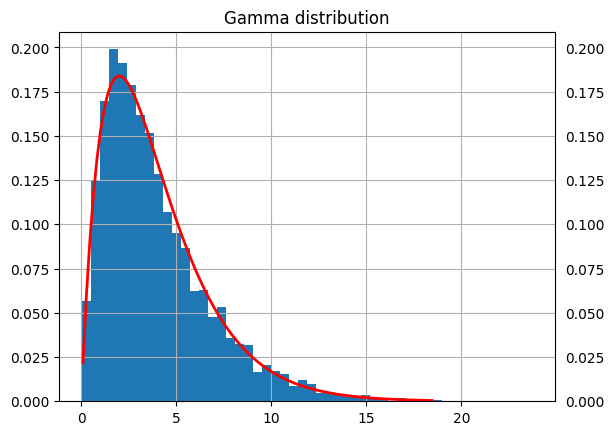

In [12]:
count, bins, ignored = plt.hist(samples, 50, density=True)

x = np.linspace(gamma.ppf(0.001,a, loc=0, scale=1.0/beta),
                gamma.ppf(0.999,a, loc=0, scale=1.0/beta), 100)
plt.plot(x, gamma.pdf(x,a, loc=0, scale=1.0/beta), 'r-', lw=2);

plt.title('Gamma distribution')
plt.tick_params(labelright=True)
plt.grid(True)

#### <font color=darkorange> Approximation de l'estimateur du maximum de vraisemblance par la méthode de Newton-Raphson </font>
On peut montrer que l'EMV n'admet pas d'expression explicite. En revanche, on peut recourir à la méthode de Newton-Raphson pour l'approcher. Plus précisément, on peut l'appliquer afin de trouver des points critiques de $(a,b)\mapsto \ell(a,b)$. 

#### Une mise à jour de Newton-Raphson
Rappelons que la méthode de Newton-Raphson est un algorithme itératif. Notons  $(a^{(t)},b^{(t)})^T$ les valeurs actuelles de paramètres. Une itération de l'algorithme consiste à calculer les nouvelles valeurs des paramètres $(a^{(t+1)},b^{(t+1)})^T$ par la formule
$$(a^{(t+1)},b^{(t+1)})^T = (a^{(t)},b^{(t)})^T-[H(a^{(t)},b^{(t)})]^{-1}\nabla\ell(a^{(t)},b^{(t)}),\qquad\qquad(*)$$
où 
$H$ désigne la matrice Hessienne de $\ell$.
Pour le gradient et l'inverse de la Hessienne on obtient (voir TD pour les calculs détaillés) 
\begin{align*}
\nabla\ell(a,b) &= \left(\frac\partial{\partial a} \ell(a,b),\frac\partial{\partial b} \ell(a,b)\right)^T
=\left(
n\log b- n (\log\Gamma)'(a)+\sum_{i=1}^n\log x_i,\quad
\frac{na}b-\sum_{i=1}^n x_i
\right)^T
\end{align*}
et
\begin{align*}
[H(a,b)]^{-1}
=\left(\begin{array}{cc}
\frac{\partial^2}{\partial^2 a} \ell(a,b)&\frac{\partial^2}{\partial a\partial b} \ell(a,b)\\
\frac{\partial^2}{\partial a\partial b} \ell(a,b)&\frac{\partial^2}{\partial^2 b} \ell(a,b)
\end{array}\right)^{-1}
&=
 \frac1{n\left(1-a(\log\Gamma)''(a)\right)}
\left(\begin{array}{cc}
a&b\\
b&b^2(\log\Gamma)''(a)
\end{array}\right)
\end{align*}

#### Question 2
Nous allons écrire une fonction qui effectue une mise à jour des paramètres. Cette fonction prend en argument les valeurs actuelles des paramètres, $a^{(t)}$ et  $b^{(t)}$, ainsi que les données. Elle renvoie les nouvelles valeurs des paramètres $a^{(t+1)}$ et  $b^{(t+1)}$ obtenues par $(*)$. 
On peut calculer directement les dérivées de $\log\Gamma$ (voir par exemple https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.polygamma.html). Une alternative est d'utiliser `autograd` grâce à `import autograd` afin de différencier automatiquement toute fonction. On pourra ainsi utiliser la version adaptée de la fonction Gamma : `from autograd.scipy.special import gamma as agamma`.
- Ecrire une fonction `gamma_logpdf` qui prend en entrée des échantillons et qui renvoie la fonction logvraisemblance associée à ces échantillons. `gamma_logpdf` renvoie donc une fonction et non l'évaluation d'une fonction en point. Vérifier la validité de votre fonction en l'évaluant sur le même échantillon que précédemment.
- En utilisant `autograd` écrire une fonction `NR_update` qui effectue une mise à jour des paramètres.

Une aide pour l'utilisation de `autograd` peut être trouvée ici https://github.com/HIPS/autograd/blob/master/docs/tutorial.md (ce n'est pas crucial pour ce TP mais vous y trouverez des éléments supplémentaires utiles).

In [85]:
# Version avec autograd
# On utilise la version autograd de la fonction Gamma afin de pouvoir 
# différencier automatiquement la logvraisemblance
import autograd.numpy as np
import autograd
from autograd.scipy.special import gamma as agamma
def gamma_logpdf(x):
    """
    Inputs
    ----------
    x: samples
    
    Outputs
    -------
    logp: loglikelihood function of the samples
    """
    
    # A completer
    def loglike(params):
        n = len(x)
        a = params[0]
        beta = params[1]
        
        return n*a*np.log(beta) - n*np.log(agamma(a)) + (a-1)*np.sum(np.log(x)) - beta*np.sum(x)

    return loglike

In [60]:
gammalpdf = gamma_logpdf(samples)
gammalpdf([a,beta])

-11331.581118105987

In [81]:
def NR_update(f, x0):
    
    # A completer
    grad_like = autograd.grad(f)
    hess_like = autograd.hessian(f)

    new_x = x0 - np.linalg.inv(hess_like(x0)) @ grad_like(x0)
    return new_x

#### Initialisation, Itérations & critère d'arrêt

- La méthode de Newton nécessite un point d'initialisation $(a^{(0)},b^{(0)})^T$. C'est à l'utilisateur de le choisir. Nous verrons l'importance d'un bon choix du point initial.

- La méthode de Newton-Raphson consiste à répéter les mises à jour décrites ci-dessus pour $t\geq$ par une boucle jusqu'à convergence. Il nous faut alors un critère d'arrêt qui vérifie après chaque itération si l'algorithme a convergé. 

- Plusieurs critères d'arrêt sont envisageable. On commence simplement par fixer un nombre maximum d'itérations.


#### Question 3
- Ecrire une fonction, nommée `mle_gamma()`, qui approche l'estimateur du maximum de vraisemblance en utilisant la méthode de Newton-Raphson. Elle prend en argument les données et les valeurs initiales $a^{(0)}$ et $b^{(0)}$. En partant de ces valeurs initiales on itère des mises à jour des paramètres selon la méthode de Newton jusqu'à convergence. Utilisez comme critère d'arrêt le nombre `max_iter` maximum d'itérations. La fonction renvoie la suite des estimations et de leur logvraisemblance au fil des itérations.

- Tracez la suite des estimations et de leur logvraisemblance au fil des itérations.



In [74]:
def mle_gamma(f, x0, maxiter=50):
    """
    Inputs
    ----------
    f: function to be optimized
    x0: initial parameter estimate
    maxiter: maximum number of updates
    
    Outputs
    -------
    a, b: sequences of estimators
    loglik: sequence of loglikelihood along iterations
    """
    
    # A completer
    a = [x0[0]]
    b = [x0[1]]
    loglik = [f(x0)]

    new_x = NR_update(f, x0)
    a.append(new_x[0])
    b.append(new_x[1])
    loglik.append(f(new_x))
    compt = 1

    while(compt<maxiter):
        x0 = new_x
        new_x = NR_update(f, x0)
        a.append(new_x[0])
        b.append(new_x[1])
        loglik.append(f(new_x))
        compt+=1

    return a, b, loglik

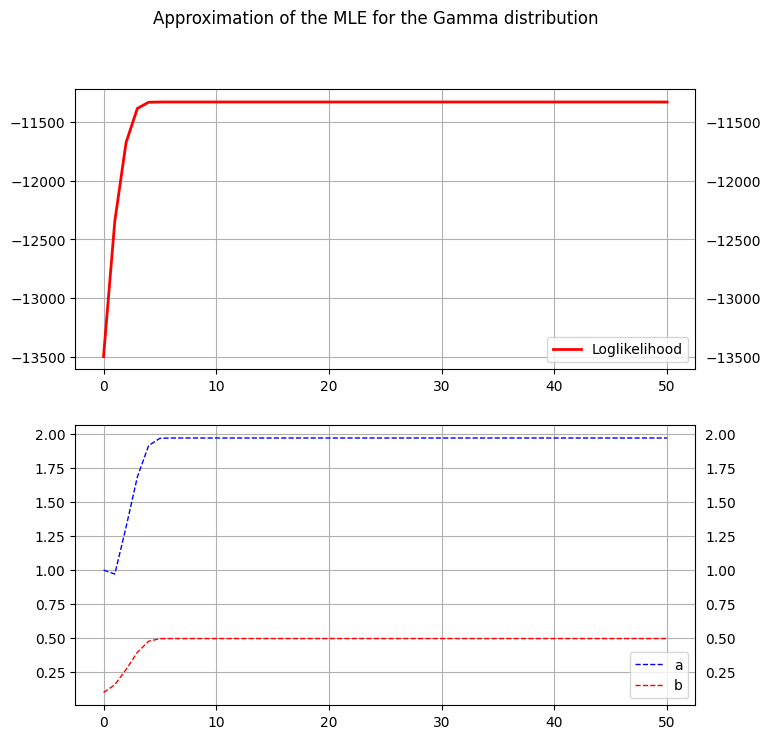

In [88]:
x0 = np.array([1,0.1])
f = gamma_logpdf(samples)
a, b, loglik = mle_gamma(f, x0)

fig, axs = plt.subplots(2, figsize=(8, 8))

fig.suptitle('Approximation of the MLE for the Gamma distribution')
axs[0].plot(loglik, 'r-', lw=2, label = 'Loglikelihood');
axs[0].tick_params(labelright=True)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(a, 'b--', lw=1, label = 'a');
axs[1].plot(b, 'r--', lw=1, label = 'b');
axs[1].tick_params(labelright=True)
axs[1].grid(True)
axs[1].legend();

#### Question 4
Testez différentes valeurs de paramètres $a$ et $b$ ainsi que différentes tailles d'échantillons et différentes estimations initiales. Pour commencer, initialisez toujours avec les vraies valeurs des paramètres. Dans ce cas, l'algorithme doit converger très rapidement. Si ce n'est pas le cas, votre programme contient des erreurs qu'il faut corriger !

In [ ]:
# true parameters
a_star, b_star = 2, 0.5
scale_star = 1.0/b_star
# number of initial points
p = 5
# different number of samples
n = np.array([100,1000,2500])
init_params = np.random.rand(p,2)

# A completer
for N in n:
    samples = np.random.gamma(a_star, scale_star, N)
    for x0 in p:
        x0 = np.array([1,0.1])
        f = gamma_logpdf(samples)
        a, b, loglik = mle_gamma(f, x0)



#### Question 5
On observe parfois que les estimations produisent des erreurs. Il arrive que la fonction `NR_update()` renvoie des valeurs négatives pour `a` et/ou `b` (ce qui n'est pas admissible du point de vue d'interprétation de $a$ et $b$ comme paramètres de la loi Gamma, mais la méthode de Newton ne respecte pas le domaine de définition). Dans ce cas, le calcul de la fonction de log-vraisemblance produit des erreurs. Modifiez la fonction `emv_gamma()` en sorte qu'elle arrête l'algorithme dès que `NR_update()` renvoie des valeurs négatives.

Cf code de la fonction NR_update

#### Initialisation avec l'estimateur par la méthode des moments

Un autre estimateur des paramètres $a$ et $b$ dans ce modèle est donné par l'estimateur par la méthode des moments (EMM). En TD vous montrez que cet estimateur est donné par
$$\tilde a_n = \frac{\bar X_n^2}{s_n^2},\qquad \tilde b_n = \frac{\bar X_n}{s_n^2},$$
où $s_n^2=n^{-1}\sum_{i=1}^n(X_i-\bar X_n)^2$.



#### Question 6
Ecrire une fonction nommée `emm_gamma()` qui prend en argument les observations et renvoie l'estimateur par la méthode des moments de $a$ et $b$.



In [ ]:
# On utilise la version autograd de la fonction Gamma afin de pouvoir 
# différencier automatiquement la logvraisemblance
def emm_gamma(x):
    """
    Inputs
    ----------
    x: samples
    
    Outputs
    -------
    params: estimators obtained with the methods of moments
    """
    # A completer

## Question 8
Etudier de nouveau la convergence de l'algorithme sur des données simulées lors la méthode de Newton-Raphson est initialisée avec l'estimateur des moments.

In [ ]:
# A completer

#### <font color=darkorange> Comparaison de l'EMV et de l'EMM </font>
On veut comparer les deux estimateurs, EMV et EMM, des paramètres de la loi Gamma. 
Pour cela nous allons comparer empiriquement les variables aléatoires $\|\hat\theta-\theta\|^2$ obtenues avec les deux méthodes.


#### Question 9
Ecrire un programme qui (i) génère un grand nombre de jeux de données de loi Gamma, (ii) évalue les deux estimateurs sur ces données et (iii) propose un boxplot des erreurs quadratiques pour les deux estimateurs.

In [ ]:
# true parameters
a_star, b_star = 2, 0.5
scale_star = 1.0/b_star
param_star = np.array([a_star,b_star])
# number of observations
n = 2000 
# number of independent repetitions
p = 50


# A completer